> Code to accompany **Chapter 6: Methods for Generating Adversarial Perturbation**

# ResNet50 Foolbox Saliency Attack

## Get a Foolbox model from our Keras one

Create a Foolbox model from our Keras one. 

In [1]:
# Import the model
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import helper function
import sys
sys.path.append('..')
from strengtheningdnns.image_utils import image_from_file

# Get the ResNet50 network using the imagenet trained weights
model = ResNet50(weights='imagenet', include_top=True)
#keras.backend.set_learning_phase(0)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Select our non adversarial image

In [2]:
original_image_path = '../images/koala.jpg'
x = image_from_file(original_image_path, [224,224])


(?, ?, ?)
Re-scaling image to  [224, 224]


In [19]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

x_preds = model.predict(np.expand_dims(preprocess_input(x), 0))
y = np.argmax(x_preds)
y_name = decode_predictions(x_preds, top=1)[0][0][1]
print("Prediction for image: ", y_name)

Prediction for image:  koala


# ResNet50 Pre-processing

The Foolbox model is able to perform pre-processing on the image to make it suitable to ResNet50. This involves normalising the data around the ImageNet mean RGB values on which the classifier was initially trained. The ```preprocessing``` variable defines the means for this pre-processing step. The equivalent normalisation is done in ```keras.applications.resnet50.preprocess_input``` - the function that we have called previously to prepare input for ResNet50. To understand this pre-processing in greater detail and try it for yourself, take a look at the Jupyter notebook: https://github.com/katywarr/strengthening-dnns/blob/master/chapter4/resnet50_preprocessing.ipynb.

In [8]:
preprocessing = (np.array([103.939, 116.779, 123.68]), 1)

ResNet50 was trained on images with the channels ordered BGR, rather than RGB. This step switches the channels of the image data to BGR. This is another step in ```keras.applications.resnet50.preprocess_input.```

In [5]:
x_bgr = x[..., ::-1]

## Import the model
Import the model passing the information required for pre-processing.

In [9]:
import foolbox

# Temporary using Keras Model to get around bug that looks like: 
# https://github.com/bethgelab/foolbox/issues/164 
fmodel = foolbox.models.KerasModel(model, bounds=(0, 255), 
                                   preprocessing=preprocessing)
#fmodel = foolbox.models.TensorFlowModel.from_keras(model, 
#                                                   bounds=(0, 255), 
#                                                   preprocessing=preprocessing)

Instructions for updating:
Use tf.cast instead.


## Define the attack specificity

[foolbox.criteria](https://foolbox.readthedocs.io/en/latest/modules/criteria.html) defines the attach specificity (targeted versus untargeted) and the probability threshold required. 
 

In [10]:
attack_criterion = foolbox.criteria.Misclassification()

## Define the attack method

In [11]:
attack = foolbox.attacks.SaliencyMapAttack(fmodel, criterion=attack_criterion)

## Run the attack

In [12]:
adversarial = attack(input_or_adv = x_bgr, label = y, unpack = False)

In [17]:
x_adv = adversarial.image[..., ::-1]

x_adv_preds = model.predict(preprocess_input(x_adv[np.newaxis].copy()))
y_adv = np.argmax(x_adv_preds)
y_adv_name = decode_predictions(x_adv_preds, top=1)[0][0][1]
print(print("Prediction for image: ", y_adv_name))

Prediction for image:  weasel
None


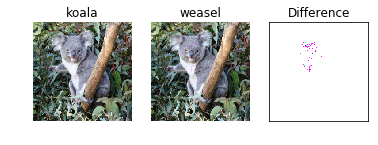

In [28]:
import matplotlib.pyplot as plt

plt.figure()

# Plot the original image
plt.subplot(1, 3, 1)
plt.title(y_name)
plt.imshow(x)  
plt.axis('off')

# Plot the adversarial image
plt.subplot(1, 3, 2)
plt.title(y_adv_name)
plt.imshow(x_adv)  
plt.axis('off')

# Plot the difference
plt.subplot(1, 3, 3)
plt.title('Difference')
difference = x_adv - x
# Set differences that haven't changed to 255 so they don't show on the plot 
difference[difference == 0] = 255 
plt.imshow(abs(difference))
plt.xticks([])
plt.yticks([])

plt.show()
#plt.savefig("ch6_code_foolbox_saliency.pdf", format='pdf', dpi=1000)